## Obtaining Data

In [108]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [14]:
data = pd.read_csv('data.csv',encoding='utf-8')
data = data.astype(str)
tweets = pd.DataFrame(data['tweet_text'])

## Scrubbing/Cleaning Data

### DataFrame treatment

In [15]:
#preview of data
data.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,nan,No emotion toward brand or product
6,nan,nan,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [16]:
#stats on data
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9288,9288,9288
unique,9168,10,5
top,nan,nan,No emotion toward brand or product
freq,27,5997,5389


In [24]:
# Get names of indexes for which column Age has value 30
indexNames = data[data['emotion_in_tweet_is_directed_at'] == 'nan' ].index
# Delete these row indexes from dataFrame
data.drop(indexNames , inplace=True)

data.dropna()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9272,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9274,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9275,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9280,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [70]:
data=data.rename(columns={'emotion_in_tweet_is_directed_at':'Brand','is_there_an_emotion_directed_at_a_brand_or_product':'Sentiment'})

In [71]:
#stats without nan in tweet column
data.describe()

,tweet_text,Brand,Sentiment
count,3291,3291,3291
unique,3247,9,4
top,rt mention love mention sxsw quot appl come co...,iPad,Positive emotion
freq,4,946,2672


In [72]:
#Changing column info to assist with encoding later
product_dict = {"iPhone":'Apple','iPad or iPhone App': 'Apple','iPad':'Apple','nan':'none','Android':'Google','Android App':'Google','Other Google product or service':'Google','Other Apple product or service':'Apple'}
sentiment_dict = {'Negative emotion': 'Negative','Positive emotion':'Positive','No emotion toward brand or product':'Neutral', "I can't tell": 'Neutral'}
data = data.replace({"Brand": product_dict})
data = data.replace({'Sentiment':sentiment_dict})


In [73]:
data.head(10)

,tweet_text,Brand,Sentiment
0,wesley g iphon hr tweet rise austin dead need ...,Apple,Negative
1,jess know fludapp awesom ipad iphon app like a...,Apple,Positive
2,swonderlin wait ipad also sale sxsw,Apple,Positive
3,sxsw hope year festiv crashi year iphon app sxsw,Apple,Negative
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive
7,sxsw start ctia around corner googleio hop ski...,Google,Positive
8,beauti smart simpl idea rt madebymani thenextw...,Apple,Positive
9,count day sxsw plu strong canadian dollar mean...,Apple,Positive
10,excit meet samsungmobileu sxsw show sprint gal...,Google,Positive
11,find amp start impromptu parti sxsw hurricanep...,Google,Positive


In [74]:
data.describe()

,tweet_text,Brand,Sentiment
count,3291,3291,3291
unique,3247,2,3
top,rt mention love mention sxsw quot appl come co...,Apple,Positive
freq,4,2409,2672


### Twitter data

In [75]:
data.head(10) #preview of what data looks like
tweets = data['tweet_text']
len(tweets)

3291

In [76]:
data.describe()

,tweet_text,Brand,Sentiment
count,3291,3291,3291
unique,3247,2,3
top,rt mention love mention sxsw quot appl come co...,Apple,Positive
freq,4,2409,2672


In [131]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
stopword_list = stopwords.words('english')
stopword_list.append([',','rt','mention','link'])
for tweet in tweets:
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    tweet = tweet.lower()
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in stopword_list]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamaalsmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
data['tweet_text'] = corpus #so that dataframe has cleaned tweets

In [133]:
#Creation of Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 3000)
X = cv.fit_transform(corpus).toarray()
y = data.iloc[:, 1].values

In [134]:
##Tokenize data and then generate FreqDist
from nltk import word_tokenize
tokens = word_tokenize(','.join(map(str,corpus)))

In [135]:
#FreqDist
from nltk import FreqDist
freq = FreqDist(tokens)
most_used_words = freq.most_common(100)
most_used_words = pd.DataFrame(most_used_words, columns=['word','count'])
most_used_words.reset_index(drop=True,inplace=True)


## Exploratory Data Analysis

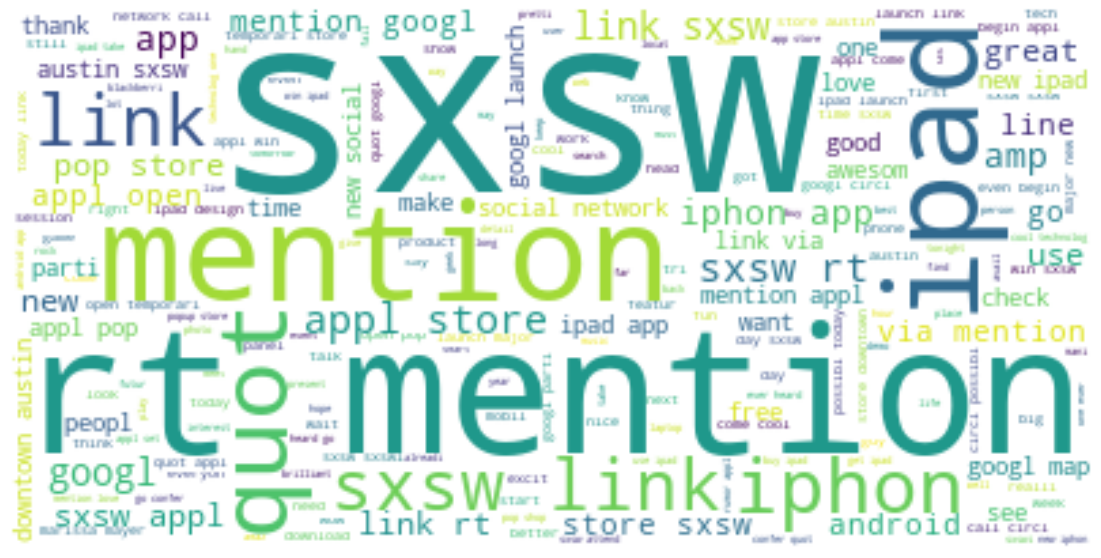

In [147]:
#Wordcloud of popular words
text = " ".join(tweet for tweet in data.tweet_text)
plt.figure(figsize=(35,10))
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["mention", "link", "rt",])

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Top 10 Common Phrases')

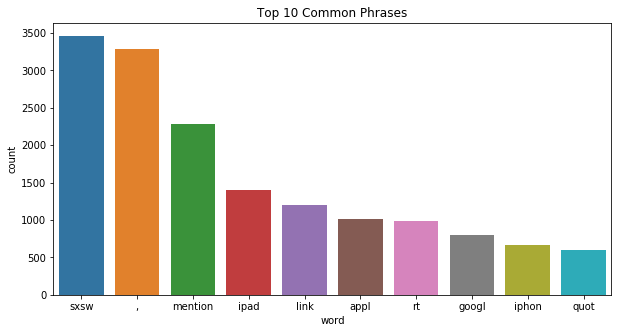

In [136]:
top10_words = most_used_words[:10]
top10_words.head()

plt.figure(figsize=(10,5))
sns.barplot(x='word',y='count',data=top10_words)
plt.title('Top 10 Common Phrases')

### Popularity of the Two Brands

Text(0.5, 0, 'Company')

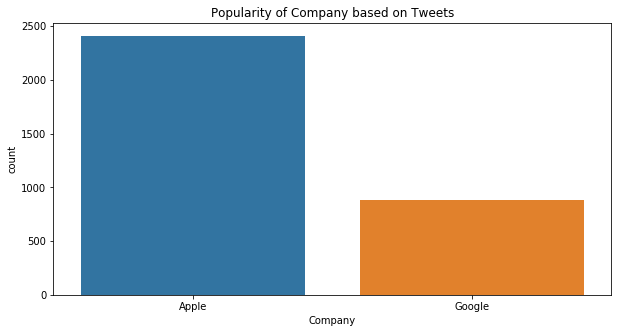

In [137]:
#Count of how many times each Brand is mentioned
plt.figure(figsize=(10,5))
sns.countplot(x="Brand",data=data)
plt.title('Popularity of Company based on Tweets')
plt.xlabel('Company')

Despite only having two inputs (Apple & Other Apple product or service) when compared to Google that had four inputs (Google,Android, Android App, Other Google product or service), Apple was discussed more in the tweets according to the data.

One might conclude that the launch of the iPad2 was a major event that Apple marketed well and built suspense amongst the tech community.

Text(0.5, 1.0, 'Attendee Sentiment Expressed in Tweets')

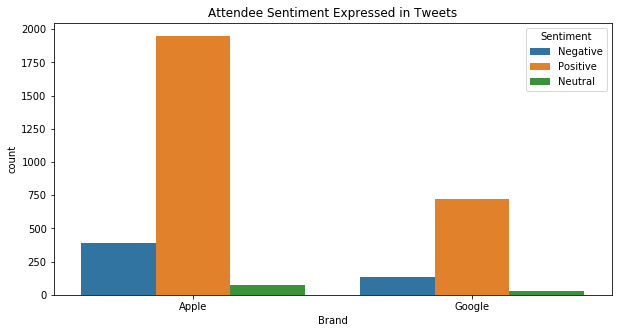

In [138]:
#Sentiment distribution for each Brand
plt.figure(figsize=(10,5))
sns.countplot(x='Brand',hue='Sentiment',data=data)
plt.title('Attendee Sentiment Expressed in Tweets')

In [139]:
#from textblob import textblob
#data['polarity'] = data['tweet_text'].map(lambda text: TextBlob(text).sentiment.polarity)
data['review_len'] = data['tweet_text'].astype(str).apply(len)
data['word_count'] = data['tweet_text'].apply(lambda x: len(str(x).split()))

In [140]:
data.head()

,tweet_text,Brand,Sentiment,review_len,word_count
0,wesley g iphon hr tweet rise austin dead need ...,Apple,Negative,72,13
1,jess know fludapp awesom ipad iphon app like a...,Apple,Positive,82,15
2,swonderlin wait ipad also sale sxsw,Apple,Positive,35,6
3,sxsw hope year festiv crashi year iphon app sxsw,Apple,Negative,48,9
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive,107,17


Text(0.5, 1.0, 'Length of Tweets by Brand')

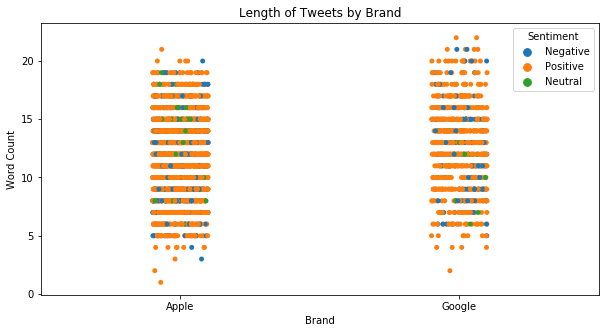

In [141]:
#review length compared against tweets
plt.figure(figsize=(10,5))
sns.stripplot(x='Brand',y='word_count',hue='Sentiment',data=data)
plt.xlabel('Brand')
plt.ylabel('Word Count')
plt.title('Length of Tweets by Brand')

## Modeling